# Pricing European Call Options 

In [1]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit_finance.circuit.library import LogNormalDistribution

In [2]:
import matplotlib.pyplot as plt

import numpy as np

from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem, AmplitudeEstimation,FasterAmplitudeEstimation
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit_finance.circuit.library import LogNormalDistribution

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
from qiskit.tools.visualization import plot_histogram
import math
from qiskit import schedule, QuantumCircuit, transpile, IBMQ
from qiskit import IBMQ


In [3]:
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem, AmplitudeEstimation,FasterAmplitudeEstimation

In [4]:
# number of qubits to represent the uncertainty
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)

In [5]:
# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 1.896

# set the approximation scaling for the payoff function
c_approx = 0.25

In [7]:
from qiskit.circuit.library import *
import numpy as np
import matplotlib.pyplot as plt


import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *
from qiskit.circuit import ParameterVector
from qiskit import Aer
from qiskit.opflow import X, Z, I
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal

In [8]:
seed = 50
algorithm_globals.random_seed = seed
qi = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=seed, seed_simulator=seed)

In [8]:
def twolocal(n_qubits,params, reps):
    qc = QuantumCircuit(n_qubits)
    j=0
    for rep in range(reps):
        for i in range(n_qubits):
            qc.ry(params[j],i)
            j+=1
        for i in range(n_qubits):
            qc.rz(params[j],i)
            j+=1
        for i in range(n_qubits-1):
            qc.cx(i,i+1)
    for i in range(n_qubits):
        qc.ry(params[j],i)
        j+=1
    for i in range(n_qubits):
        qc.rz(params[j],i)
        j+=1
    return qc
    

In [9]:
def optionpricing(thetas,n_qubits,rep):
    two = twolocal(n_qubits,thetas,rep)
    qc = QuantumCircuit(n_qubits)
    qc.append(uncertainty_model, range(num_uncertainty_qubits))
    qc.barrier()
    qc.append(two,range(n_qubits))
    qc.barrier()
    qc.rz(np.pi,num_uncertainty_qubits)
    qc.barrier()
    qc.append(two.inverse(),range(n_qubits))

    
    qc.measure_all()
    return qc

In [16]:
from qiskit.test.mock import FakeVigo
from qiskit.providers.aer import AerSimulator
from qiskit.test.mock import FakeParis
fake_backend = AerSimulator.from_backend(FakeParis())
aer_backend=qiskit.Aer.get_backend('aer_simulator')
shots=300

/home/justids/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/providers/aer/noise/device/models.py:266: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (78724.73839768364 > 2 * 17977.586136949183). Truncating to maximum value.
  " Truncating to maximum value.", UserWarning)
/home/justids/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/providers/aer/noise/device/models.py:266: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (151392.40575779957 > 2 * 69749.41874968237). Truncating to maximum value.
  " Truncating to maximum value.", UserWarning)
/home/justids/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/providers/aer/noise/device/models.py:266: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (78724.73839768364 > 2 * 17977.586136949183). Truncating to maxi

In [11]:
def optcir(thetas,p_target,rep,backend):
    qc=optionpricing( thetas,num_uncertainty_qubits+1,rep )
    t_qc = transpile(qc,
                        backend)
    qobj = assemble(t_qc,
                    shots=shots)
    job = backend.run(qobj)
    result = job.result().get_counts()
    
    counts = np.array(list(result.values()))
    states = np.array(list(result.keys()))
    onecount=0
    for i in range(len(states)):
        if states[i][0]=='1':
            onecount+=counts[i]
    p=onecount/shots
    return np.sqrt((p-p_target)**2)
    # return p

In [13]:
init_v=np.random.randn(16)*np.pi
optcir(init_v,0.1804,1)

0.0796

In [14]:

import scipy
init_v=np.random.randn(24)*np.pi
sol=scipy.optimize.minimize(fun=optcir, x0=init_v, method='COBYLA' , args=(0.1804,2,aer_backend) )

In [15]:
sol

     fun: 0.07293333333333335
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 215
  status: 1
 success: True
       x: array([-1.61696824, -1.6988663 , -0.96550036, -7.2514855 , -0.16273223,
       -7.54017915,  2.80613894, -2.71050828, -4.88166151, -1.390966  ,
        0.5292685 , -2.28791437,  5.46073688,  1.73191729,  1.62639223,
       -2.79135043,  2.23759277, -5.19861237, -7.30721431,  1.24163438,
       -0.61136129,  1.93476104,  6.21801914, -0.99956631])

In [145]:
init_v

array([-1.82960118,  3.7519316 ,  4.26863432,  4.23059335, -2.63954102,
       -1.56428537, -4.99048433,  2.65359151,  3.51776573,  2.58499663,
       11.52820786, -5.04414197, -3.44379432, -2.44716549, -0.83993993,
       -3.32675344, -3.22804137, -1.22678202, -7.01088083, -5.83891542,
        5.00485305, -1.88243318, -2.19650123,  2.85218298,  3.21019517,
       -3.37473402,  2.02818054,  2.53953577, -2.07319427, -0.53989074,
       -0.45967069,  0.99577425])

In [88]:
class LearningCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---

        # ---------------------------

        self.backend = backend
        self.shots = shots
        self.n_qubits=n_qubits
    
    
    def optionpricing(n_qubits, thetas):
        two = twolocal(n_qubits,thetas,2)
        qc = QuantumCircuit(n_qubits)
        qc.append(uncertainty_model, range(num_uncertainty_qubits))
        qc.barrier()
        qc.append(two,range(n_qubits))
        qc.barrier()
        qc.rz(np.pi,num_uncertainty_qubits)
        qc.barrier()
        qc.append(two.inverse(),range(n_qubits))

        
        qc.measure_all()
        return qc
        
        
    def run(self,thetas):
        qc=self.optionpricing(self.n_qubits, thetas)
        t_qc = transpile(qc,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots)
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys()))
        onecount=0
        for i in range(len(states)):
            if states[i][0]==1:
                onecount+=counts[0]
        
        # Compute probabilities for each state
        # Get state expectation

        
        return torch.tensor(onecount/self.shots)

In [84]:
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
        Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F
from qiskit_machine_learning.connectors import TorchConnector

In [89]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input.tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.qc = LearningCircuit(num_uncertainty_qubits+1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.qc, self.shift)

In [93]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = self.hybrid(x)
        return x

In [90]:
n_samples = 100
theta_inputs=torch.randn(24)*torch.pi
train_loader = torch.utils.data.DataLoader(theta_inputs, batch_size=1, shuffle=True)


In [92]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100


3.141592653589793

In [35]:
simulator = qiskit.Aer.get_backend('aer_simulator')

circuit = LearningCircuit(n_qubits=4, backend=simulator, shots=100,thetas=np.random.rand(24))
print('Expected value for rotation pi {}'.format(circuit.run()[0]))
circuit.qc.draw()

CircuitError: 'Cannot bind parameters (θ) not present in the circuit.'

In [19]:
two = TwoLocal(num_uncertainty_qubits+1, ['ry','rz'], 'cz', 'linear', reps=2, insert_barriers=True)
qc = QuantumCircuit(num_uncertainty_qubits+1)
qc.append(uncertainty_model, range(num_uncertainty_qubits))
qc.barrier()
qc+=two
qc.barrier()
qc.rz(np.pi,num_uncertainty_qubits)
qc.barrier()
qc+=two.inverse()


/home/justids/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  """
/home/justids/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  if __name__ == '__main__':


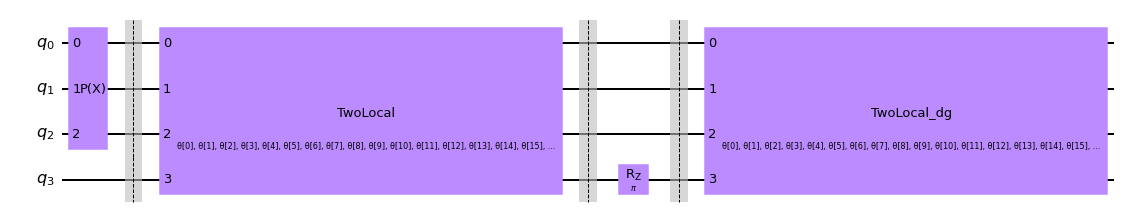

In [20]:
qc.draw('mpl')

In [7]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 1.896

# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))

# draw the circuit
european_call_objective.draw()

┌────┐
q5_0: ┤0   ├
      │    │
q5_1: ┤1   ├
      │    │
  q6: ┤2 F ├
      │    │
a0_0: ┤3   ├
      │    │
a0_1: ┤4   ├
      └────┘

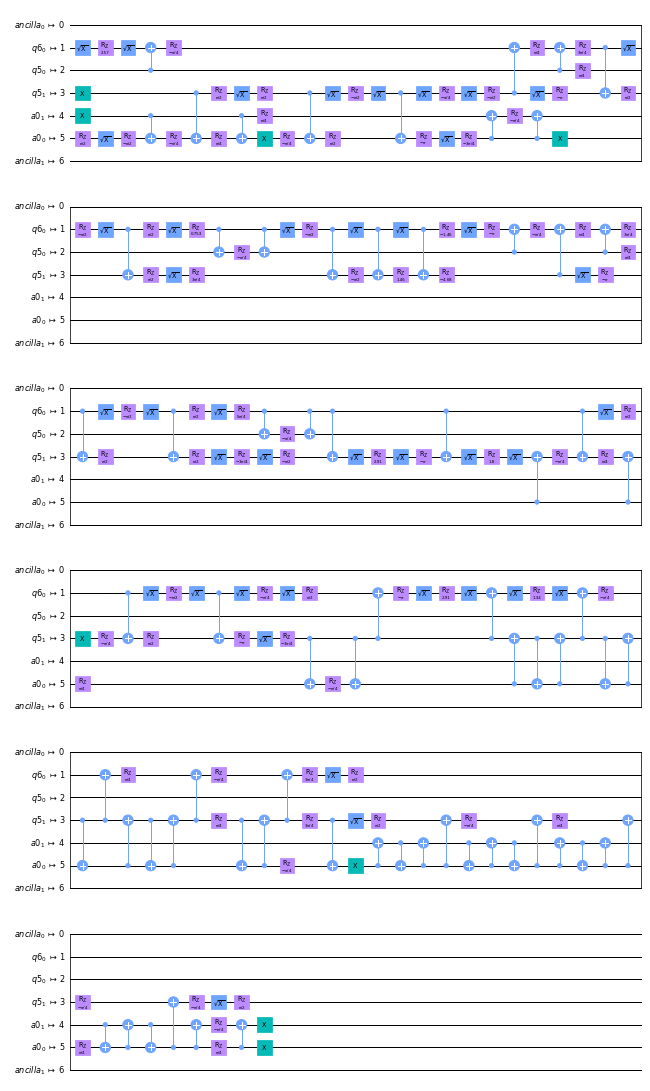

In [11]:
from qiskit import transpile

# ('p', 1), ('cry', 2), ('ry', 1), ('cx', 2), ('x', 1), ('u', 1), ('ccx', 3)
target_basis = ['p', 'ry', 'cry','cx','x','ccx','u']
decomposed = transpile(european_call_objective,
                       ibmq_backend, 
                       optimization_level=3)  # 0 for no optimization, 3 is max
decomposed.draw('mpl',scale=0.5)

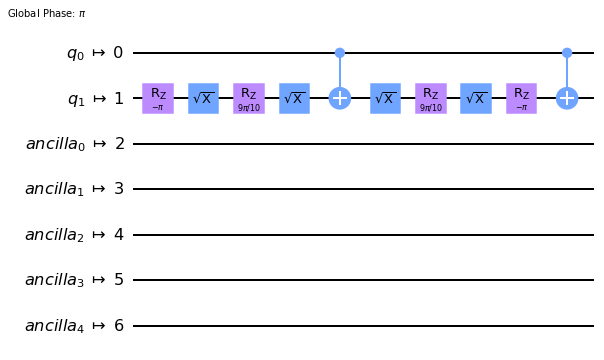

In [12]:
cc=QuantumCircuit(2)
#cc.ry(np.pi/5,1)
cc.cry(np.pi/5,0, 1)
cc = transpile(cc, ibmq_backend)
cc.draw('mpl')

### Evaluate Expected Payoff

Instead of constructing these circuits manually, Qiskit's finance module offers the `EuropeanCallPricing` circuit, which already implements this functionality as building block.

In [11]:
from qiskit_finance.applications.estimation import EuropeanCallPricing

european_call_pricing = EuropeanCallPricing(
    num_state_qubits=num_uncertainty_qubits,
    strike_price=strike_price,
    rescaling_factor=c_approx,
    bounds=(low, high),
    uncertainty_model=uncertainty_model,
)

In [12]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
problem = european_call_pricing.to_estimation_problem()
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
result = ae.estimate(problem)

conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (european_call_pricing.interpret(result)))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.1623
Estimated value:    	0.1673
Confidence interval:	[0.1623, 0.1722]


### Evaluate Delta

The Delta is a bit simpler to evaluate than the expected payoff.
Similarly to the expected payoff, we use a comparator circuit and an ancilla qubit to identify the cases where $S_T > K$.
However, since we are only interested in the probability of this condition being true, we can directly use this ancilla qubit as the objective qubit in amplitude estimation without any further approximation.

In [13]:
from qiskit_finance.applications.estimation import EuropeanCallDelta

european_call_delta = EuropeanCallDelta(
    num_state_qubits=num_uncertainty_qubits,
    strike_price=strike_price,
    bounds=(low, high),
    uncertainty_model=uncertainty_model,
)

In [14]:
european_call_delta._objective.decompose().draw()

state_0: ───────■─────────────────────────────■──
                │                             │  
state_1: ───────┼────■───────────────────■────┼──
         ┌───┐  │    │            ┌───┐  │    │  
state_2: ┤ X ├──┼────┼─────────■──┤ X ├──┼────┼──
         ├───┤  │    │       ┌─┴─┐└───┘  │    │  
state_3: ┤ X ├──┼────┼───────┤ X ├───────┼────┼──
         └───┘┌─┴─┐  │       └─┬─┘       │  ┌─┴─┐
 work_0: ─────┤ X ├──■─────────┼─────────■──┤ X ├
              └───┘┌─┴─┐┌───┐  │  ┌───┐┌─┴─┐└───┘
 work_1: ──────────┤ X ├┤ X ├──■──┤ X ├┤ X ├─────
                   └───┘└───┘     └───┘└───┘

In [15]:
european_call_delta_circ = QuantumCircuit(european_call_delta._objective.num_qubits)
european_call_delta_circ.append(uncertainty_model, range(num_uncertainty_qubits))
european_call_delta_circ.append(
    european_call_delta._objective, range(european_call_delta._objective.num_qubits)
)

european_call_delta_circ.draw()

┌───────┐┌──────┐
q_0: ┤0      ├┤0     ├
     │       ││      │
q_1: ┤1 P(X) ├┤1     ├
     │       ││      │
q_2: ┤2      ├┤2     ├
     └───────┘│  ECD │
q_3: ─────────┤3     ├
              │      │
q_4: ─────────┤4     ├
              │      │
q_5: ─────────┤5     ├
              └──────┘

In [16]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
problem = european_call_delta.to_estimation_problem()

# construct amplitude estimation
ae_delta = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)

In [17]:
result_delta = ae_delta.estimate(problem)

In [18]:
conf_int = np.array(result_delta.confidence_interval_processed)
print("Exact delta:    \t%.4f" % exact_delta)
print("Esimated value: \t%.4f" % european_call_delta.interpret(result_delta))
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact delta:    	0.8098
Esimated value: 	0.8063
Confidence interval: 	[0.8005, 0.8120]


In [19]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright